# 16. Parameter fitting

## Numerical experiments - Week 20/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using BlackBoxOptim
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./datautils.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .DataUtils

## 1. Time-dependent Dantigny dataset generation

The estimated $P_{\textrm{max}}$, $\tau_g$ and $\nu$ parameters from Ijadpanahsaravi et al. [1] allow the reconstruction of time-dependent courses of the germination percentage. This is useful for providing more data points to fit the different inducer-inhibitor interaction models outlined in the previous notebook.

In [3]:
t_max = 48
df_germination_rebuilt = parse_ijadpanahsaravi_data()
dantigny_data, times, sources, densities = generate_dantigny_dataset(df_germination_rebuilt, t_max)
size(dantigny_data)

(3, 4, 1000)

(1000,)
(1000,)


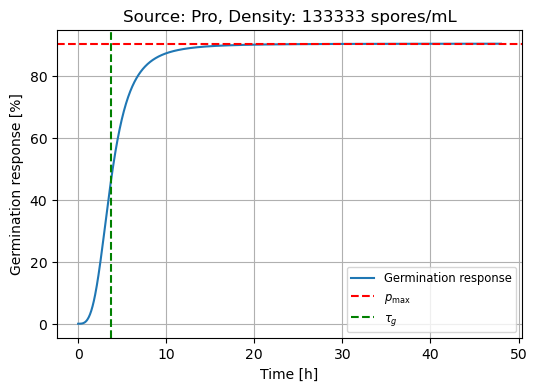

In [21]:
src_idx = 3
density_idx = 3
params = filter(row -> (row[:CarbonSource] == sources[src_idx]) && (row[:Density] == densities[density_idx]), df_germination_rebuilt)
plot_dantigny_time_course(params[!, :Pmax][1], params[!, :tau][1], params[!, :d][1], germination_responses=dantigny_data[src_idx, density_idx, :], times=times, title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")

## 2. Fitting procedures

### 2.1. Independent induction/inhibition

As determined previously, the germination probability in the first model follows the formula

$$
\begin{equation}
p(\textrm{germination})=\Phi{\left(\frac{s-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-20, 1e-4),
    :σ_γ => (1e-20, 1e-4),
    :s => (1e-5, 1.0),
    :μ_ω => (1e-5, 1.0),
    :σ_ω => (1e-5, 1.0)
)

fit_model_to_data("independent", def_params, dantigny_data, times, sources, densities, bounds)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.97 secs, 4 evals, 2 steps, fitness=2342.041421147
1.53 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 1.0000), fitness=1900.038093328
2.09 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 1.0000), fitness=1900.038093328
2.60 secs, 10 evals, 5 steps, improv/step: 0.600 (last = 1.0000), fitness=1900.038093328
3.17 secs, 12 evals, 6 steps, improv/step: 0.667 (last = 1.0000), fitness=1900.038093328
4.20 secs, 16 evals, 8 steps, improv/step: 0.625 (last = 0.5000), fitness=1435.136375769
5.04 secs, 20 evals, 10 steps, improv/step: 0.500 (last = 0.0000), fitness=1435.136375769
5.97 secs, 24 evals, 12 steps, improv/step: 0.500 (last = 0.5000), fitness=1435.136375769
6.69 secs, 27 evals, 14 steps, improv/step: 0.571 (last = 1.0000), fitness=1435.136375769
7.69 secs, 31 evals, 16 steps, 

6-element Vector{Float64}:
 0.9805959120877046
 0.17485106413449372
 0.033146676617256274
 0.0004565010874081502
 2.7852302454180916e-5
 9.99999999349847e-5

0.0
172.97297297297297


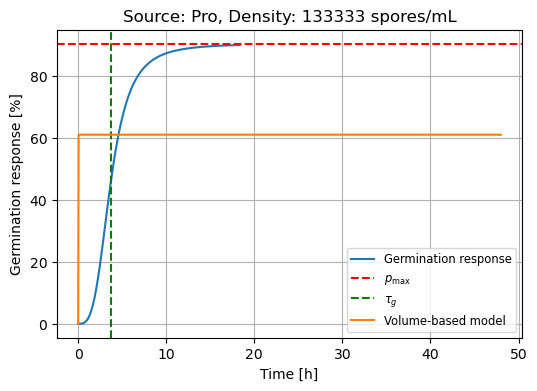

In [38]:
p_opt = [0.9805959120877046,
0.17485106413449372,
0.033146676617256274,
0.0004565010874081502,
2.7852302454180916e-5,
9.99999999349847e-5]

s = p_opt[1]
μ_ω = p_opt[2]
σ_ω = p_opt[3]
Pₛ = p_opt[4]
μ_γ = p_opt[5]
σ_γ = p_opt[6]

src_idx = 3
density_idx = 3
params = filter(row -> (row[:CarbonSource] == sources[src_idx]) && (row[:Density] == densities[density_idx]), df_germination_rebuilt)
# plot_dantigny_time_course(params[!, :Pmax][1], params[!, :tau][1], params[!, :d][1], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")

germination_responses = germination_response_combined_independent(s, μ_ω, σ_ω, Pₛ, densities[density_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], times)
# germination_responses = germination_response_simple(densities[density_idx], Pₛ, μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], times)
compare_time_course_to_dantigny(germination_responses, times, params[!, :Pmax][1], params[!, :tau][1], params[!, :d][1], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")

## References

- [1] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .